In [165]:
# Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from textwrap import wrap
import time
from sklearn.svm import LinearSVC
from sklearn import svm
from glob import glob
import PIL
import re


# for data preparation and others
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

# models tried
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from scipy.special import softmax
from sklearn.metrics import roc_auc_score, roc_curve

In [166]:
#Data Preprocessing

df = pd.read_csv("df_new.csv", delimiter=",", header = None)
X = df.iloc[1:]
X = np.asarray(X.values)
X = np.delete(X, 0, 1)
X = np.transpose(X)

y = df.iloc[0]
y = y[1:]
y = np.asarray(y)
y = np.transpose(y)

features_names = df.iloc[1:]
features_names = features_names.iloc[:,0]
features_names = np.asarray(features_names)
target_names = df.iloc[0]
target_names = target_names[1:]
target_names = np.asarray(target_names)
target_names = np.transpose(target_names)


indx = []
for i in range(len(features_names)):
  indx.append(i)
print(len(features_names))

234002


In [167]:
#splitting the data into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)


In [168]:
#normalizing or scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [169]:
#filter technique (Mutual Information [MI])
startTime = time.time()
mi = mutual_info_classif(X_train, y_train, discrete_features='auto', n_neighbors=3, copy=True, random_state=42)
endTime = time.time()
print('Time: ' + str(endTime - startTime))


Time: 764.8045947551727


In [170]:
#oraganizing MI data
gains = np.asarray(mi)
indexes = np.where(gains != 0)[0]
print(len(indexes))


128725


In [171]:
#Confusion matrix (128725 features of MI) *******

y_test_binary = y_test.copy()
y_train_binary = y_train.copy()


class_mapping = {"EarlyFlowering": 0, "LateFlowering": 1, "MediumFlowering": 2}
y_test_binary = np.array([class_mapping[label] for label in y_test_binary])
y_train_binary = np.array([class_mapping[label] for label in y_train_binary])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



it = sorted(range(len(gains)), key = lambda sub: gains[sub])[-4:]
startTime = time.time()
x_train = X_train[:, it]
x_test = X_test[:, it]
Y_train = y_train[:]
Y_test = y_test[:]
x_train = x_train.astype('float32')
X_test = x_test.astype('float32')

clf = LinearSVC(random_state=42)
clf.fit(x_train, Y_train)
scores = clf.score(x_test, Y_test)
endTime = time.time()
print('Score: ' + str(scores))
print('Time: ' + str(endTime - startTime))
y_pred = clf.predict(x_test)


print(confusion_matrix(Y_test,y_pred))
print(classification_report(Y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))




Score: 0.8620689655172413
Time: 0.0034902095794677734
[[ 2  0  0]
 [ 0 12  2]
 [ 0  2 11]]
                 precision    recall  f1-score   support

 EarlyFlowering       1.00      1.00      1.00         2
  LateFlowering       0.86      0.86      0.86        14
MediumFlowering       0.85      0.85      0.85        13

       accuracy                           0.86        29
      macro avg       0.90      0.90      0.90        29
   weighted avg       0.86      0.86      0.86        29

0.8620689655172413
(np.float64(0.8620689655172413), np.float64(0.8620689655172413), np.float64(0.8620689655172413), None)


Class Early: ROC AUC=1.000
Class Medium: ROC AUC=0.861
Class Late: ROC AUC=0.890
No Skill: ROC AUC=0.500
Model: ROC AUC=0.917


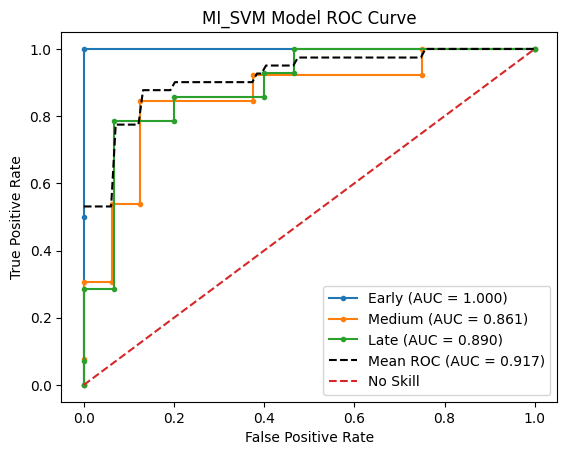

In [172]:

#ROC AUC calculations for the 4 features of MI Model
#changing the class to discrete numbers for ROC AUC calculation

class_mapping = {"EarlyFlowering": 0, "MediumFlowering": 1, "LateFlowering": 2}
short_class_mapping = {0: 'Early', 1: 'Medium', 2: 'Late'}

y_test_binary = np.array([class_mapping[label] for label in y_test])
y_train_binary = np.array([class_mapping[label] for label in y_train])

model = LinearSVC(random_state=42)
model.fit(x_train, y_train_binary)

lr_scores = model.decision_function(X_test)

lr_probs = softmax(lr_scores, axis=1)

Y_test_one_hot = label_binarize(y_test_binary, classes=[0, 1, 2])

ns_probs = np.zeros((len(y_test_binary), 3))
ns_probs[:, 2] = 1  

auc_scores = []
for i in range(3):
    auc = roc_auc_score(Y_test_one_hot[:, i], lr_probs[:, i])
    auc_scores.append(auc)
    print(f'Class {short_class_mapping[i]}: ROC AUC=%.3f' % (auc))

try:
    ns_auc = roc_auc_score(Y_test_one_hot, ns_probs, multi_class='ovr')
    lr_auc = roc_auc_score(Y_test_one_hot, lr_probs, multi_class='ovr')
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (lr_auc))
except ValueError as e:
    print(f"Error calculating ROC AUC: {e}")

plt.figure()
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)
for i in range(3):
    fpr, tpr, _ = roc_curve(Y_test_one_hot[:, i], lr_probs[:, i])
    plt.plot(fpr, tpr, marker='.', label=f'{short_class_mapping[i]} (AUC = {auc_scores[i]:.3f})')
    mean_tpr += np.interp(mean_fpr, fpr, tpr, left=0, right=1)

mean_tpr /= 3
plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', label=f'Mean ROC (AUC = {np.mean(auc_scores):.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("MI_SVM Model ROC Curve")

plt.legend()

plt.show()


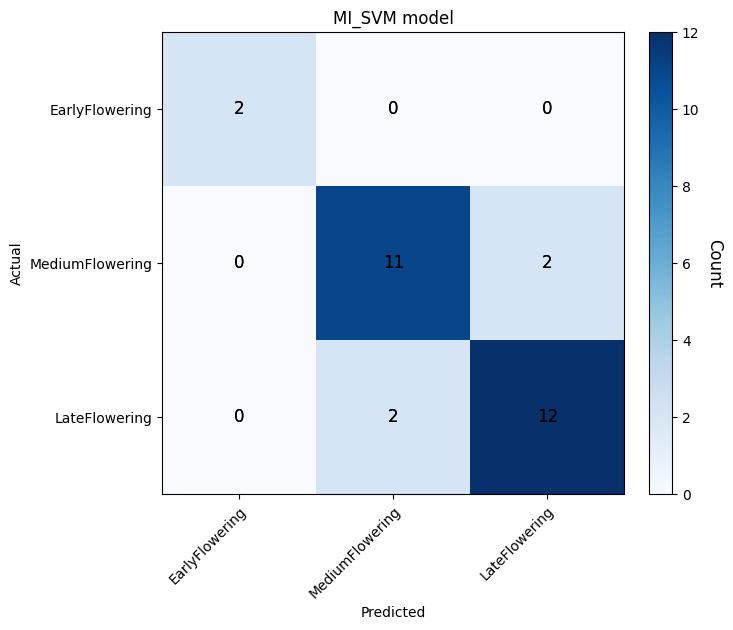

In [173]:

matrix_data = np.array([[2, 0, 0],
                        [0, 11, 2],
                        [0, 2, 12]])
#Just here changed Medium
class_names = ['EarlyFlowering', 'MediumFlowering', 'LateFlowering']


fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(matrix_data, cmap="Blues")

for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, f"{matrix_data[i, j]:.0f}",
                       ha="center", va="center", color="black", fontsize=12)

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, fontsize=10)
ax.set_yticklabels(class_names, fontsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel("Predicted", fontsize=10)
plt.ylabel("Actual", fontsize=10)
plt.title("MI_SVM model", fontsize=12)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        ax.text(j, i, f"{matrix_data[i, j]:.0f}",
                ha="center", va="center", color="black", fontsize=12)

cbar = ax.figure.colorbar(im,  ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Count", rotation=-90, va="bottom", fontsize=12)

plt.show()


In [174]:
res = []
for l in ['EarlyFlowering', 'LateFlowering' , 'MediumFlowering']:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test)==l,
                                                      np.array(y_pred)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

In [175]:
pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

#weighted specificity
specificity = ((res[0][1]*2)+(res[1][1]*14)+(res[2][1]*13))/29
print('Specificity: ', specificity)

#weighted sensitivity (recall)
sensitivity = ((res[0][2]*2)+(res[1][2]*14)+(res[2][2]*13))/29
print("Sensitivity: ", sensitivity)

Specificity:  0.8795977011494253
Sensitivity:  0.8620689655172413


In [176]:
#Balanced Accuracy
Balanced_Accuracy = (specificity+sensitivity)/2
print ("Balanced_Accuracy:", Balanced_Accuracy)

Balanced_Accuracy: 0.8708333333333333


In [177]:
pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

,class,specificity,sensitivity
0,EarlyFlowering,1.000000,1.000000
1,LateFlowering,0.866667,0.857143
2,MediumFlowering,0.875000,0.846154


In [178]:
###Random forest
#to get the common features between top 4 MI features and the features of the 197 trees in the Random forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
ST = time.time()
regressor = RandomForestClassifier(n_estimators=197, random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
sorted_features = sorted (zip(map(lambda x: round(x, 4), regressor.feature_importances_), indx),reverse=True)
important_f = []
  

for s in sorted_features:
  if s[0] != 0:
    important_f.append(s[1])
important_f = np.transpose(important_f)
important_f = np.asarray(important_f)

#checking the similarities in the first 4 features in MI with features used in RF (n_estimators = 197)
it = sorted(range(len(gains)), key = lambda sub: gains[sub])[-4:]
similarity = []
count = 0
for f in important_f:
  for t in it:
    if (f == t):
      count = count + 1
      similarity.append(f)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))
print("the number of important features used: ", len(important_f))
print ("number of similar features: ", len(similarity))  

ET = time.time()
print("time: ", ET - ST)
print("\n")


0.6551724137931034
[[ 1  0  1]
 [ 0 10  4]
 [ 0  5  8]]
                 precision    recall  f1-score   support

 EarlyFlowering       1.00      0.50      0.67         2
  LateFlowering       0.67      0.71      0.69        14
MediumFlowering       0.62      0.62      0.62        13

       accuracy                           0.66        29
      macro avg       0.76      0.61      0.66        29
   weighted avg       0.67      0.66      0.65        29

(np.float64(0.6666666666666666), np.float64(0.6551724137931034), np.float64(0.6547760602457393), None)
the number of important features used:  2840
number of similar features:  4
time:  3.9284017086029053




Class Early: ROC AUC=1.000
Class Medium: ROC AUC=0.668
Class Late: ROC AUC=0.738
No Skill: ROC AUC=0.500
Model: ROC AUC=0.802


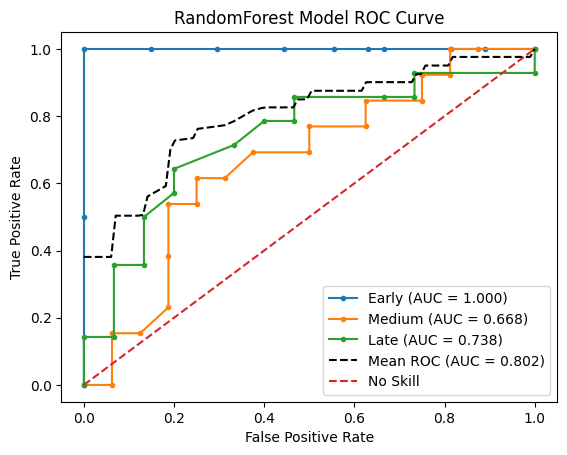

In [179]:
#ROC AUC calculations for the 2840 features of 197 trees in Random Forest Model
class_mapping = {"EarlyFlowering": 0, "MediumFlowering": 1, "LateFlowering": 2}
reverse_class_mapping = {v: k for k, v in class_mapping.items()}  

short_class_mapping = {0: 'Early', 1: 'Medium', 2: 'Late'}

y_test_binary = np.array([class_mapping[label] for label in y_test])
y_train_binary = np.array([class_mapping[label] for label in y_train])

model = RandomForestClassifier(n_estimators=197, random_state=42)
model.fit(X_train, y_train_binary)

lr_probs = model.predict_proba(X_test)

Y_test_one_hot = label_binarize(y_test_binary, classes=[0, 1, 2])

ns_probs = np.zeros((len(y_test_binary), 3))
ns_probs[:, 2] = 1  

auc_scores = []
for i in range(3):
    auc = roc_auc_score(Y_test_one_hot[:, i], lr_probs[:, i])
    auc_scores.append(auc)
    print(f'Class {short_class_mapping[i]}: ROC AUC=%.3f' % (auc))

try:
    ns_auc = roc_auc_score(Y_test_one_hot, ns_probs, multi_class='ovr')
    lr_auc = roc_auc_score(Y_test_one_hot, lr_probs, multi_class='ovr')
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (lr_auc))
except ValueError as e:
    print(f"Error calculating ROC AUC: {e}")

plt.figure()
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)
for i in range(3):
    fpr, tpr, _ = roc_curve(Y_test_one_hot[:, i], lr_probs[:, i])
    plt.plot(fpr, tpr, marker='.', label=f'{short_class_mapping[i]} (AUC = {auc_scores[i]:.3f})')
    # Interpolate tpr to match mean_fpr
    mean_tpr += np.interp(mean_fpr, fpr, tpr, left=0, right=1)

mean_tpr /= 3
plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', label=f'Mean ROC (AUC = {np.mean(auc_scores):.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("RandomForest Model ROC Curve")

plt.legend()

plt.show()


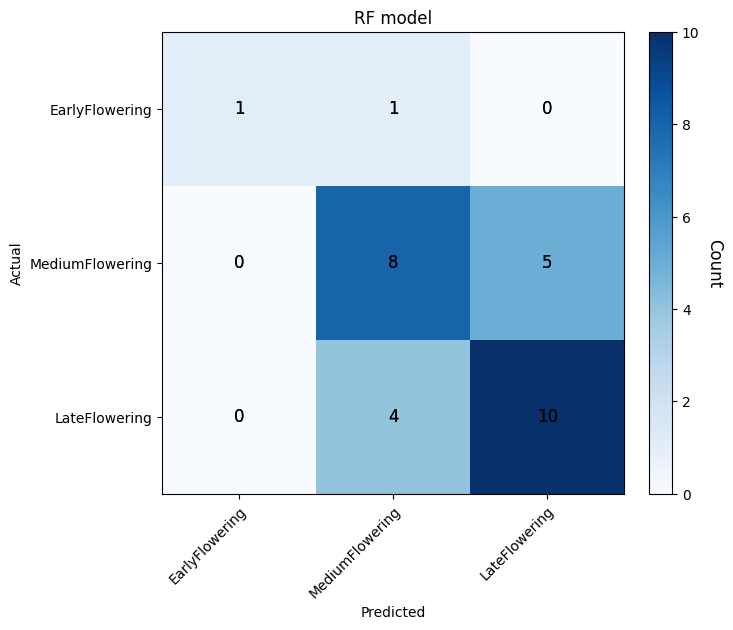

In [180]:


matrix_data = np.array([[1, 1, 0],
                        [0, 8, 5],
                        [0, 4, 10]])
#Just here changed Medium
class_names = ['EarlyFlowering', 'MediumFlowering', 'LateFlowering']


fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(matrix_data, cmap="Blues")

for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, f"{matrix_data[i, j]:.0f}",
                       ha="center", va="center", color="black", fontsize=12)

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, fontsize=10)
ax.set_yticklabels(class_names, fontsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel("Predicted", fontsize=10)
plt.ylabel("Actual", fontsize=10)
plt.title("RF model", fontsize=12)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        ax.text(j, i, f"{matrix_data[i, j]:.0f}",
                ha="center", va="center", color="black", fontsize=12)

cbar = ax.figure.colorbar(im,  ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Count", rotation=-90, va="bottom", fontsize=12)

plt.show()


In [181]:
res = []
for l in ['EarlyFlowering', 'LateFlowering' , 'MediumFlowering']:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test)==l,
                                                      np.array(y_pred)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])
pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

#weighted specificity
specificity = ((res[0][1]*2)+(res[1][1]*14)+(res[2][1]*13))/29
print('Specificity: ', specificity)

#weighted sensitivity (recall)
sensitivity = ((res[0][2]*2)+(res[1][2]*14)+(res[2][2]*13))/29
print("Sensitivity: ", sensitivity)

Specificity:  0.6989942528735632
Sensitivity:  0.6551724137931034


In [182]:
#Balanced Accuracy
Balanced_Accuracy = (specificity+sensitivity)/2
print ("Balanced_Accuracy:", Balanced_Accuracy)

Balanced_Accuracy: 0.6770833333333333


In [183]:
pd.DataFrame(res,columns = ['class','specificity','sensitivity'])


,class,specificity,sensitivity
0,EarlyFlowering,1.000000,0.500000
1,LateFlowering,0.666667,0.714286
2,MediumFlowering,0.687500,0.615385


In [184]:
##RFE
#The wrapper method (recursive feature elimination RFE) 53 features only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

startTime = time.time()
estimator = LinearSVC(random_state=42)
selector = RFE(estimator, n_features_to_select= 53, step=0.5)
selector = selector.fit(X_train, y_train)
endTime = time.time()
print('Time: ' + str(endTime - startTime))
# testing the model
y_pred = selector.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(selector.score(X_test, y_test))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))

print(np.count_nonzero(selector.support_ == 1))


(116, 234002)
(116,)
(29, 234002)
(29,)
Time: 11.652689456939697
0.9655172413793104
0.9655172413793104
[[ 2  0  0]
 [ 0 13  1]
 [ 0  0 13]]
                 precision    recall  f1-score   support

 EarlyFlowering       1.00      1.00      1.00         2
  LateFlowering       1.00      0.93      0.96        14
MediumFlowering       0.93      1.00      0.96        13

       accuracy                           0.97        29
      macro avg       0.98      0.98      0.98        29
   weighted avg       0.97      0.97      0.97        29

(np.float64(0.9679802955665024), np.float64(0.9655172413793104), np.float64(0.9655172413793104), None)
53


No Skill: ROC AUC=0.500
Model: ROC AUC=0.990


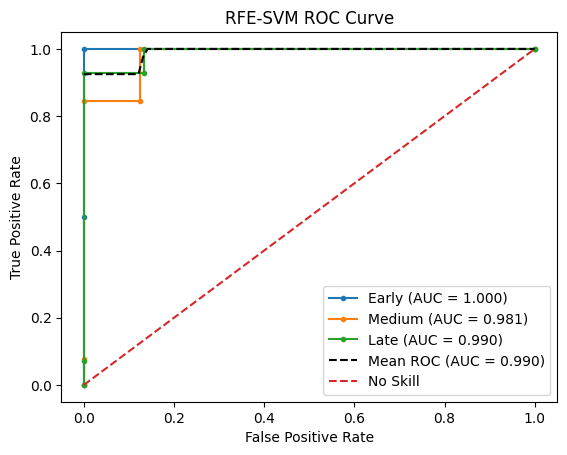

In [185]:
# ROC AUC calculations for the 53 features of RFE Model

class_mapping = {"EarlyFlowering": 0, "MediumFlowering": 1, "LateFlowering": 2}
short_class_mapping = {0: 'Early', 1: 'Medium', 2: 'Late'}

y_test_binary = np.array([class_mapping[label] for label in y_test])
y_train_binary = np.array([class_mapping[label] for label in y_train])

ns_probs = np.zeros((len(y_test_binary), 3))
ns_probs[:, 2] = 1  

svm = LinearSVC(random_state=42)
model3 = RFE(svm, n_features_to_select= 53, step=0.5)
model3 = model3.fit(X_train, y_train_binary)
lr_probs = model3.decision_function(X_test)


Y_test_one_hot = label_binarize(y_test_binary, classes=[0, 1, 2])

ns_auc = roc_auc_score(Y_test_one_hot, ns_probs, multi_class='ovr')
lr_auc = roc_auc_score(Y_test_one_hot, lr_probs, multi_class='ovr')

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Model: ROC AUC=%.3f' % (lr_auc))

plt.figure()
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)
for i in range(3):
    fpr, tpr, _ = roc_curve(Y_test_one_hot[:, i], lr_probs[:, i])
    plt.plot(fpr, tpr, marker='.', label=f'{short_class_mapping[i]} (AUC = {roc_auc_score(Y_test_one_hot[:, i], lr_probs[:, i]):.3f})')
    # Interpolate tpr to match mean_fpr
    mean_tpr += np.interp(mean_fpr, fpr, tpr, left=0, right=1)

mean_tpr /= 3
plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', label=f'Mean ROC (AUC = {np.mean([roc_auc_score(Y_test_one_hot[:, i], lr_probs[:, i]) for i in range(3)]):.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("RFE-SVM ROC Curve")

plt.legend()

plt.show()




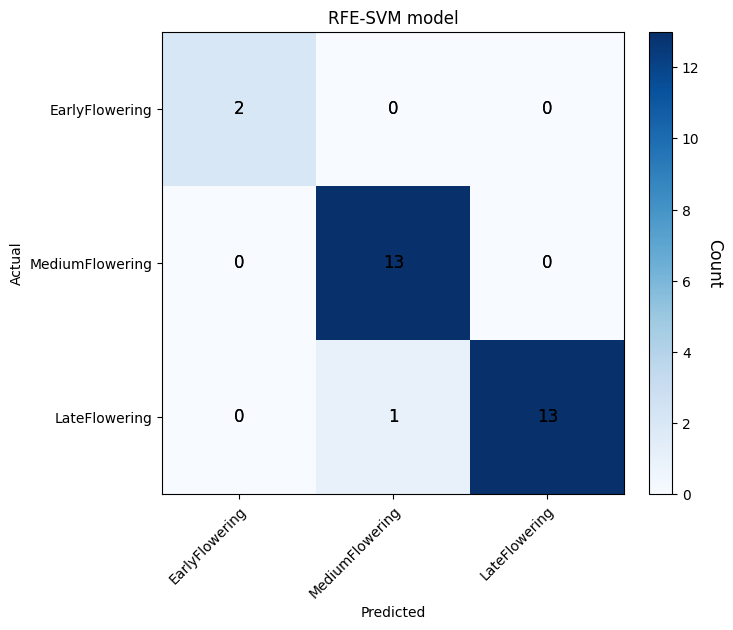

In [186]:

matrix_data = np.array([[2, 0, 0],
                        [0, 13, 0],
                        [0, 1, 13]])
#Just here changed Medium
class_names = ['EarlyFlowering', 'MediumFlowering', 'LateFlowering']


fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(matrix_data, cmap="Blues")

for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, f"{matrix_data[i, j]:.0f}",
                       ha="center", va="center", color="black", fontsize=12)

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, fontsize=10)
ax.set_yticklabels(class_names, fontsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel("Predicted", fontsize=10)
plt.ylabel("Actual", fontsize=10)
plt.title("RFE-SVM model", fontsize=12)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        ax.text(j, i, f"{matrix_data[i, j]:.0f}",
                ha="center", va="center", color="black", fontsize=12)

cbar = ax.figure.colorbar(im,  ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Count", rotation=-90, va="bottom", fontsize=12)

plt.show()


In [187]:
res = []
for l in ['EarlyFlowering', 'LateFlowering' , 'MediumFlowering']:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test)==l,
                                                      np.array(y_pred)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])
pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

#weighted specificity
specificity = ((res[0][1]*2)+(res[1][1]*14)+(res[2][1]*13))/29
print('Specificity: ', specificity)

#weighted sensitivity (recall)
sensitivity = ((res[0][2]*2)+(res[1][2]*14)+(res[2][2]*13))/29
print("Sensitivity: ", sensitivity)

Specificity:  0.9719827586206896
Sensitivity:  0.9655172413793104


In [188]:
#Balanced Accuracy
Balanced_Accuracy = (specificity+sensitivity)/2
print ("Balanced_Accuracy:", Balanced_Accuracy)

Balanced_Accuracy: 0.96875


In [189]:
pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

,class,specificity,sensitivity
0,EarlyFlowering,1.0000,1.000000
1,LateFlowering,1.0000,0.928571
2,MediumFlowering,0.9375,1.000000


In [190]:
####start common features
#Create a list with indices of RFE Features
RFE_features = np.where(selector.support_ == 1)
RFE_features = np.asarray(RFE_features)
rfe_f = []
for i in RFE_features:
  for s in i:
    rfe_f.append(s)
rfe_f = np.asarray(rfe_f)

In [191]:
#Create list with common features among techniques
similar_all = []
similar_rfe_RF = []
similar_rfe_MI = []

count = 0
for f in it:
  for t in rfe_f:
    if (f == t):
      count = count + 1
      similar_rfe_MI.append(f)
print("number of similar features between RFE and MI: ", count)

count = 0
for f in important_f:
  for t in rfe_f:
    if (f == t):
      count = count + 1
      similar_rfe_RF.append(f)
print("number of similar features between RFE and RF: ", count)

count = 0
for f in similarity:
  for t in rfe_f:
    if (f == t):
      count = count + 1
      similar_all.append(f)
print("number of similar features between RF and MI: ", len(similarity))
print("number of similar features between RFE, RF and MI: ", count)


number of similar features between RFE and MI:  4
number of similar features between RFE and RF:  28
number of similar features between RF and MI:  4
number of similar features between RFE, RF and MI:  4


In [317]:
#A LinearSVC Model using the similar features between all of them
startTime = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train = X_train[:, similar_all]
X_test = X_test[:, similar_all]
Y_train = y_train[:]
Y_test = y_test[:]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train[:]
Y_test = Y_test[:]
clf = LinearSVC(random_state=42)

clf.fit(X_train, Y_train)

endTime = time.time()
print('Score: ' + str(clf.score(X_test, Y_test)))
print('Time: ' + str(endTime - startTime))
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))


Score: 0.8620689655172413
Time: 4.434690237045288
[[ 2  0  0]
 [ 0 12  2]
 [ 0  2 11]]
                 precision    recall  f1-score   support

 EarlyFlowering       1.00      1.00      1.00         2
  LateFlowering       0.86      0.86      0.86        14
MediumFlowering       0.85      0.85      0.85        13

       accuracy                           0.86        29
      macro avg       0.90      0.90      0.90        29
   weighted avg       0.86      0.86      0.86        29

0.8620689655172413
(np.float64(0.8620689655172413), np.float64(0.8620689655172413), np.float64(0.8620689655172413), None)


In [318]:
#Save in a Data Frame
similar_all_names = []
for i in similar_all:
  similar_all_names.append(features_names[i])
df_similar_All = pd.DataFrame(similar_all_names)
df_similar_All.to_csv(r'Similar_All_Features.csv', index=False) 

Class Early: ROC AUC=1.000
Class Medium: ROC AUC=0.861
Class Late: ROC AUC=0.890
No Skill: ROC AUC=0.500
Model: ROC AUC=0.917


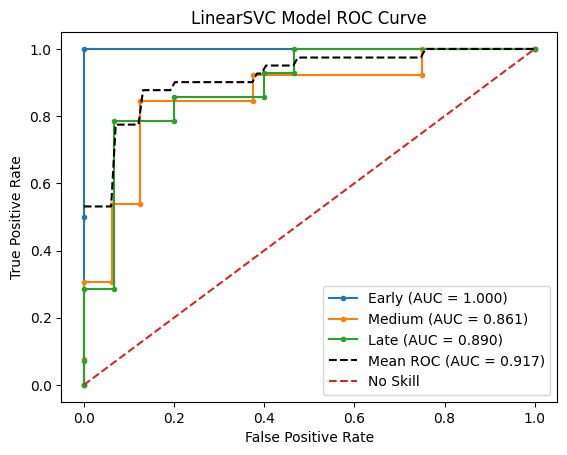

In [319]:
#ROC AUC calculations for LinearSVC Model using the similar features between all of them

class_mapping = {"EarlyFlowering": 0, "MediumFlowering": 1, "LateFlowering": 2}
short_class_mapping = {0: 'Early', 1: 'Medium', 2: 'Late'}

y_test_binary = np.array([class_mapping[label] for label in y_test])
y_train_binary = np.array([class_mapping[label] for label in y_train])

model = LinearSVC(random_state=42)
model.fit(X_train, y_train_binary)

lr_scores = model.decision_function(X_test)

lr_probs = softmax(lr_scores, axis=1)

Y_test_one_hot = label_binarize(y_test_binary, classes=[0, 1, 2])

ns_probs = np.zeros((len(y_test_binary), 3))
ns_probs[:, 2] = 1  

auc_scores = []
for i in range(3):
    auc = roc_auc_score(Y_test_one_hot[:, i], lr_probs[:, i])
    auc_scores.append(auc)
    print(f'Class {short_class_mapping[i]}: ROC AUC=%.3f' % (auc))

try:
    ns_auc = roc_auc_score(Y_test_one_hot, ns_probs, multi_class='ovr')
    lr_auc = roc_auc_score(Y_test_one_hot, lr_probs, multi_class='ovr')
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (lr_auc))
except ValueError as e:
    print(f"Error calculating ROC AUC: {e}")

plt.figure()
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)
for i in range(3):
    fpr, tpr, _ = roc_curve(Y_test_one_hot[:, i], lr_probs[:, i])
    plt.plot(fpr, tpr, marker='.', label=f'{short_class_mapping[i]} (AUC = {auc_scores[i]:.3f})')
    mean_tpr += np.interp(mean_fpr, fpr, tpr, left=0, right=1)

mean_tpr /= 3
plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', label=f'Mean ROC (AUC = {np.mean(auc_scores):.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("LinearSVC Model ROC Curve")

plt.legend()

plt.show()


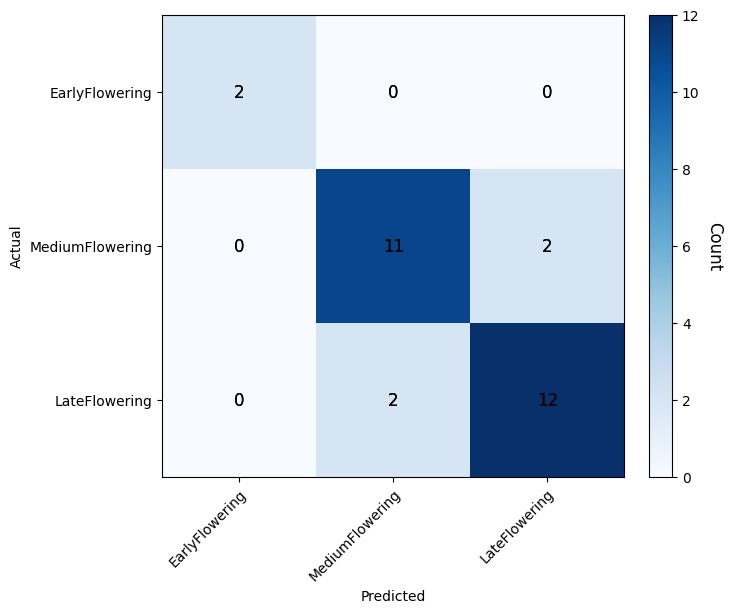

In [320]:


matrix_data = np.array([[2, 0, 0],
                        [0, 11, 2],
                        [0, 2, 12]])
#Just here changed Medium
class_names = ['EarlyFlowering', 'MediumFlowering', 'LateFlowering']


fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(matrix_data, cmap="Blues")

for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, f"{matrix_data[i, j]:.0f}",
                       ha="center", va="center", color="black", fontsize=12)

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, fontsize=10)
ax.set_yticklabels(class_names, fontsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel("Predicted", fontsize=10)
plt.ylabel("Actual", fontsize=10)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        ax.text(j, i, f"{matrix_data[i, j]:.0f}",
                ha="center", va="center", color="black", fontsize=12)

cbar = ax.figure.colorbar(im,  ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Count", rotation=-90, va="bottom", fontsize=12)

plt.show()


In [321]:
res = []
for l in ['EarlyFlowering', 'LateFlowering', 'MediumFlowering']:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test)==l,
                                                      np.array(y_pred)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])
pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

#weighted specificity
specificity = ((res[0][1]*2)+(res[1][1]*14)+(res[2][1]*13))/29
print('Specificity: ', specificity)

#weighted sensitivity (recall)
sensitivity = ((res[0][2]*2)+(res[1][2]*14)+(res[2][2]*13))/29
print("Sensitivity: ", sensitivity)

Specificity:  0.8795977011494253
Sensitivity:  0.8620689655172413


In [322]:
#Balanced Accuracy
Balanced_Accuracy = (specificity+sensitivity)/2
print ("Balanced_Accuracy:", Balanced_Accuracy)

Balanced_Accuracy: 0.8708333333333333


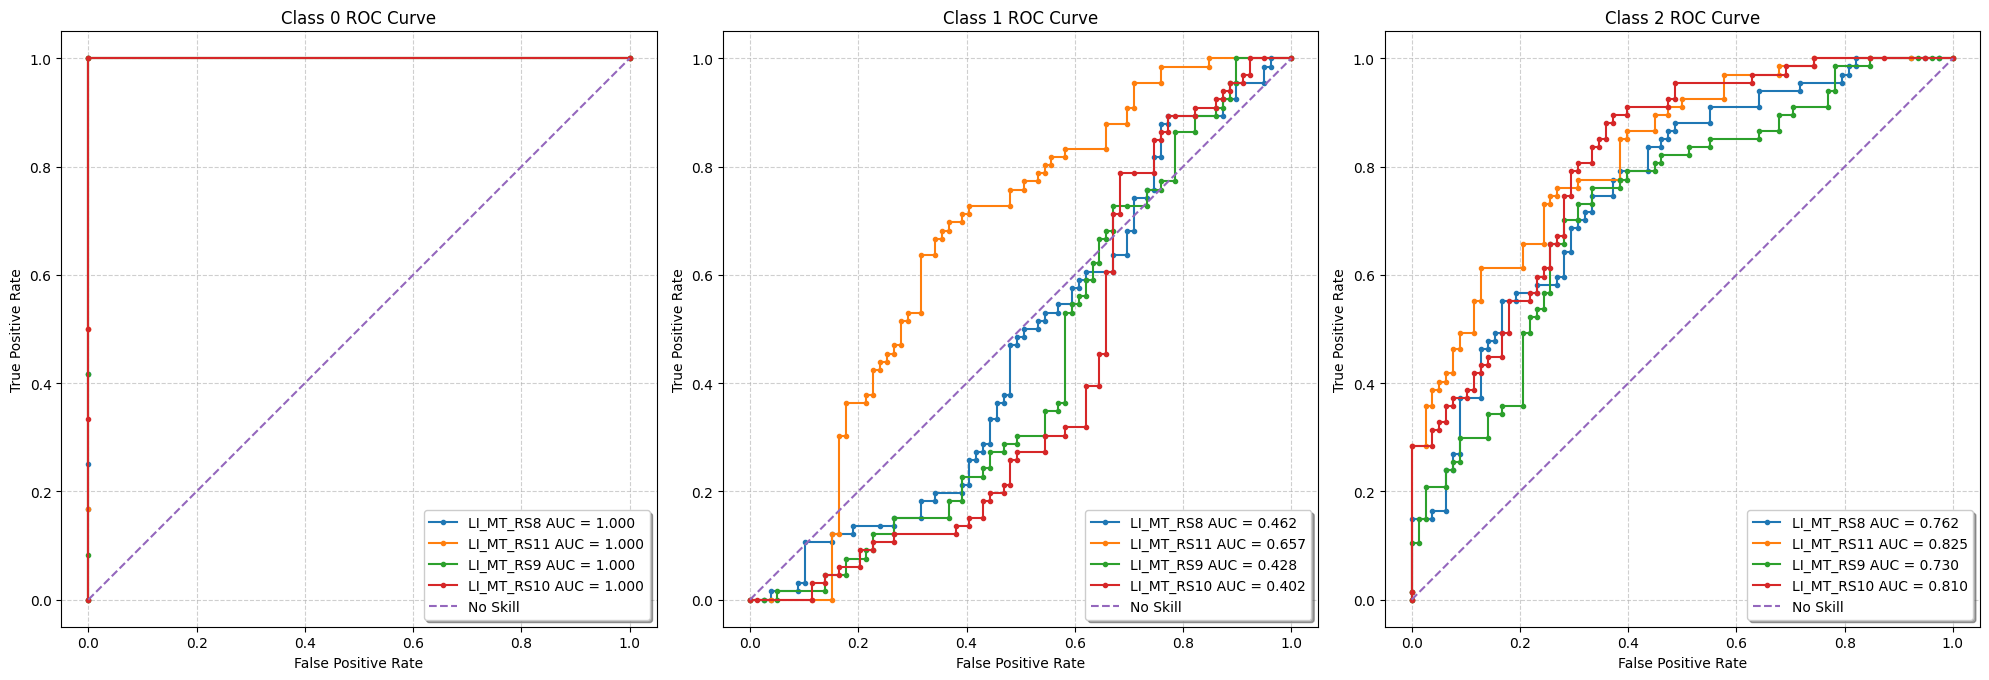

In [323]:
class_mapping = {"EarlyFlowering": 0, "MediumFlowering": 1, "LateFlowering": 2}
y_binary = np.array([class_mapping[label] for label in y])

Y_one_hot = label_binarize(y_binary, classes=[0, 1, 2])

plt.figure(figsize=(20, 20))  

for i in range(3):
    plt.subplot(1, 3, i + 1, aspect='equal') 
    plt.title(f'Class {i} ROC Curve')
    
    for idx, feature_name in zip(similar_all, similar_all_names):
        X_feature = X[:, idx].reshape(-1, 1)
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        lr_scores = cross_val_predict(LinearSVC(random_state=42), X_feature, y_binary, cv=cv, method='decision_function')
        
        if lr_scores.ndim > 1:
            y_score = lr_scores[:, i]
        else:
            y_score = lr_scores
        
        y_true = Y_one_hot[:, i]
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        
        plt.plot(fpr, tpr, marker='.', label=f'{feature_name} AUC = {auc:.3f}')
    
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right', fancybox=True, shadow=True) 
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


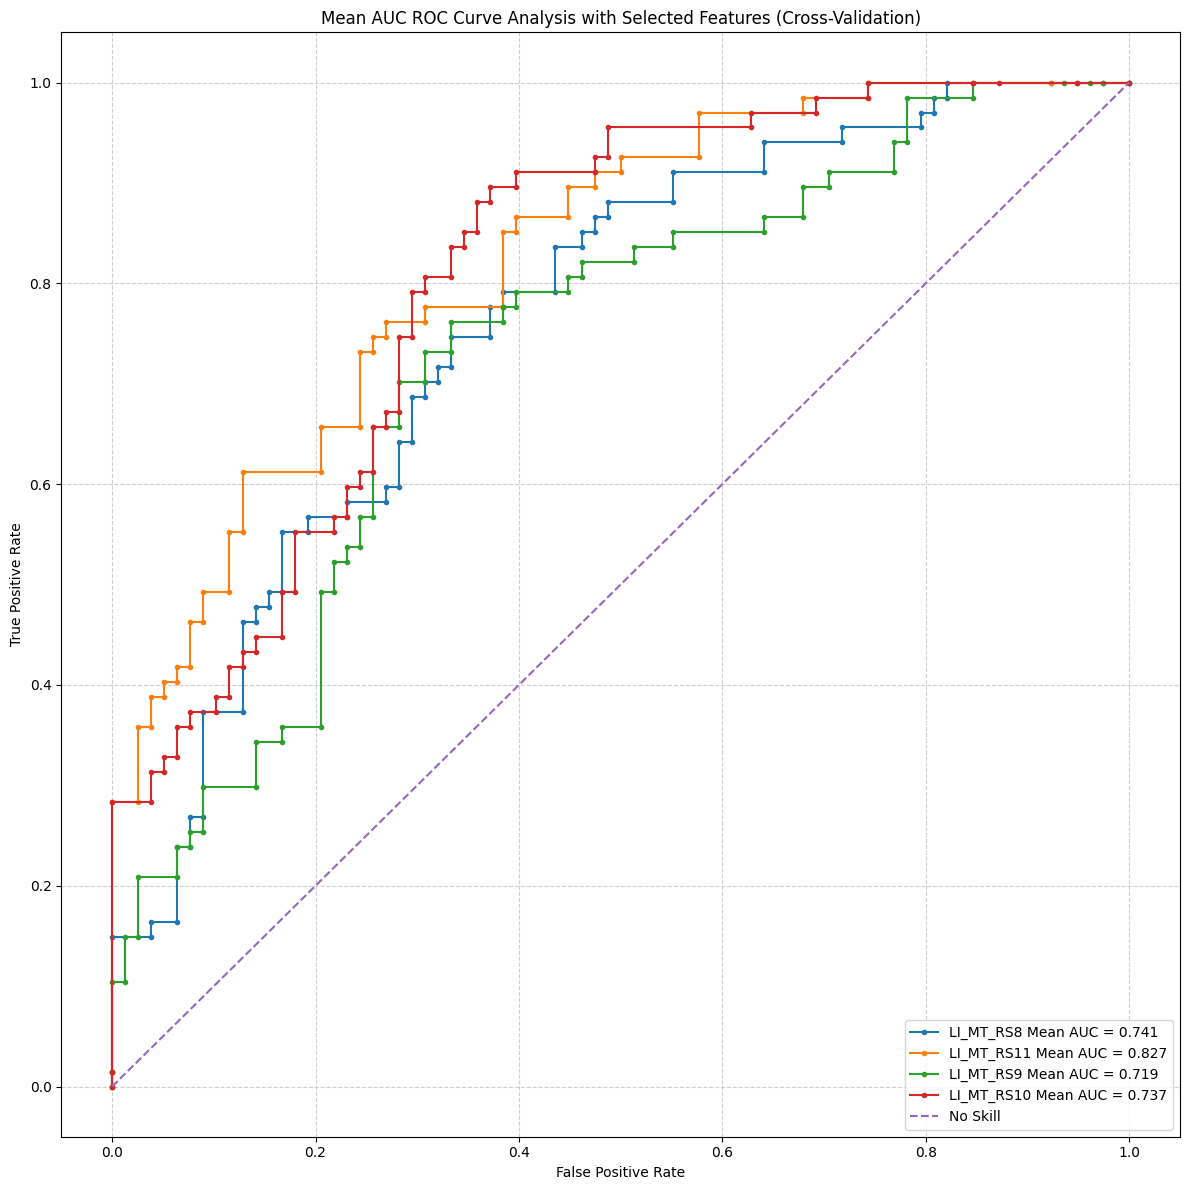

In [324]:

class_mapping = {"EarlyFlowering": 0, "MediumFlowering": 1, "LateFlowering": 2}
y_binary = np.array([class_mapping[label] for label in y])

Y_one_hot = label_binarize(y_binary, classes=[0, 1, 2])

plt.figure(figsize=(12, 12))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for idx, feature_name in zip(similar_all, similar_all_names):
    X_feature = X[:, idx].reshape(-1, 1)
    
    lr_scores = cross_val_predict(LinearSVC(random_state=42), X_feature, y_binary, cv=cv, method='decision_function')
    
    aucs = []
    
    for i in range(3):
        y_true = Y_one_hot[:, i]
        y_score = lr_scores
        
        if lr_scores.ndim > 1:
            y_score = lr_scores[:, i]
        
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        aucs.append(auc)
    
    mean_auc = np.mean(aucs)
    plt.plot(fpr, tpr, marker='.', label=f'{feature_name} Mean AUC = {mean_auc:.3f}')

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Mean AUC ROC Curve Analysis with Selected Features (Cross-Validation)")
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [325]:
####at least two techniques
#Create a list with common features between at least two techniques
common = []
zzz = []
zzz = similar_all + similar_rfe_MI + similar_rfe_RF + similarity
for i in zzz:
  if i in common:
    pass
  else:
    common.append(i)
print ("Number of common features between at least two techniques: ",len(common))

Number of common features between at least two techniques:  28


In [326]:
#A LinearSVC Model using the common features between at least two techniques
startTime = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = X_train[:, common]
X_test = X_test[:, common]
Y_train = y_train[:]
Y_test = y_test[:]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train[:]
Y_test = Y_test[:]
clf = LinearSVC(random_state=42)

clf.fit(X_train, Y_train)

endTime = time.time()
print('Score: ' + str(clf.score(X_test, Y_test)))
print('Time: ' + str(endTime - startTime))
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))


Score: 0.8620689655172413
Time: 4.432092666625977
[[ 2  0  0]
 [ 0 12  2]
 [ 0  2 11]]
                 precision    recall  f1-score   support

 EarlyFlowering       1.00      1.00      1.00         2
  LateFlowering       0.86      0.86      0.86        14
MediumFlowering       0.85      0.85      0.85        13

       accuracy                           0.86        29
      macro avg       0.90      0.90      0.90        29
   weighted avg       0.86      0.86      0.86        29

0.8620689655172413
(np.float64(0.8620689655172413), np.float64(0.8620689655172413), np.float64(0.8620689655172413), None)


In [327]:
common_all = []
for i in common:
  common_all.append(features_names[i])
df_common = pd.DataFrame(common_all)
df_common.to_csv(r'common_all.csv', index=False) 

Class Early: ROC AUC=1.000
Class Medium: ROC AUC=0.928
Class Late: ROC AUC=0.938
No Skill: ROC AUC=0.500
Model: ROC AUC=0.955


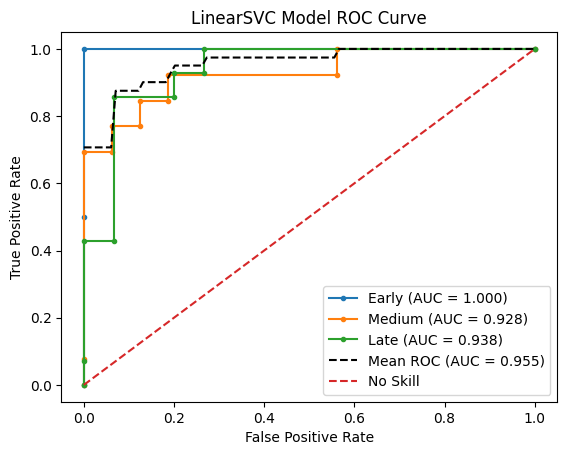

In [328]:
#ROC AUC calculations for LinearSVC Model using the common features between at least two techniques
class_mapping = {"EarlyFlowering": 0, "MediumFlowering": 1, "LateFlowering": 2}
short_class_mapping = {0: 'Early', 1: 'Medium', 2: 'Late'}

y_test_binary = np.array([class_mapping[label] for label in y_test])
y_train_binary = np.array([class_mapping[label] for label in y_train])

model = LinearSVC(random_state=42)
model.fit(X_train, y_train_binary)

lr_scores = model.decision_function(X_test)

lr_probs = softmax(lr_scores, axis=1)

Y_test_one_hot = label_binarize(y_test_binary, classes=[0, 1, 2])

ns_probs = np.zeros((len(y_test_binary), 3))
ns_probs[:, 2] = 1  

auc_scores = []
for i in range(3):
    auc = roc_auc_score(Y_test_one_hot[:, i], lr_probs[:, i])
    auc_scores.append(auc)
    print(f'Class {short_class_mapping[i]}: ROC AUC=%.3f' % (auc))

try:
    ns_auc = roc_auc_score(Y_test_one_hot, ns_probs, multi_class='ovr')
    lr_auc = roc_auc_score(Y_test_one_hot, lr_probs, multi_class='ovr')
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (lr_auc))
except ValueError as e:
    print(f"Error calculating ROC AUC: {e}")

plt.figure()
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)
for i in range(3):
    fpr, tpr, _ = roc_curve(Y_test_one_hot[:, i], lr_probs[:, i])
    plt.plot(fpr, tpr, marker='.', label=f'{short_class_mapping[i]} (AUC = {auc_scores[i]:.3f})')
    mean_tpr += np.interp(mean_fpr, fpr, tpr, left=0, right=1)

mean_tpr /= 3
plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', label=f'Mean ROC (AUC = {np.mean(auc_scores):.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("LinearSVC Model ROC Curve")

plt.legend()

plt.show()


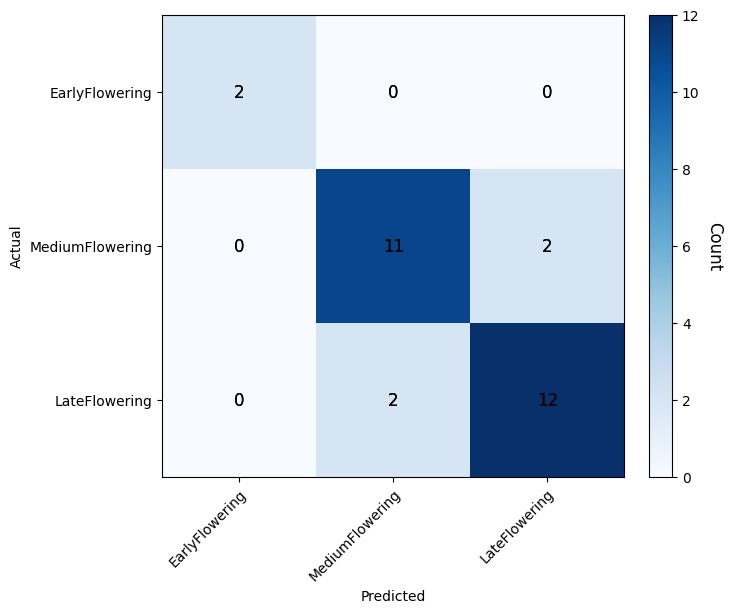

In [329]:
matrix_data = np.array([[2, 0, 0],
                        [0, 11, 2],
                        [0, 2, 12]])
#Just here changed Medium
class_names = ['EarlyFlowering', 'MediumFlowering', 'LateFlowering']


fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(matrix_data, cmap="Blues")

for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, f"{matrix_data[i, j]:.0f}",
                       ha="center", va="center", color="black", fontsize=12)

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, fontsize=10)
ax.set_yticklabels(class_names, fontsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel("Predicted", fontsize=10)
plt.ylabel("Actual", fontsize=10)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        ax.text(j, i, f"{matrix_data[i, j]:.0f}",
                ha="center", va="center", color="black", fontsize=12)

cbar = ax.figure.colorbar(im,  ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Count", rotation=-90, va="bottom", fontsize=12)

plt.show()


In [330]:
res = []
for l in ['EarlyFlowering', 'LateFlowering', 'MediumFlowering']:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test)==l,
                                                      np.array(y_pred)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])
pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

#weighted specificity
specificity = ((res[0][1]*2)+(res[1][1]*14)+(res[2][1]*13))/29
print('Specificity: ', specificity)

#weighted sensitivity (recall)
sensitivity = ((res[0][2]*2)+(res[1][2]*14)+(res[2][2]*13))/29
print("Sensitivity: ", sensitivity)

Specificity:  0.8795977011494253
Sensitivity:  0.8620689655172413


In [331]:
#Balanced Accuracy
Balanced_Accuracy = (specificity+sensitivity)/2
print ("Balanced_Accuracy:", Balanced_Accuracy)

Balanced_Accuracy: 0.8708333333333333


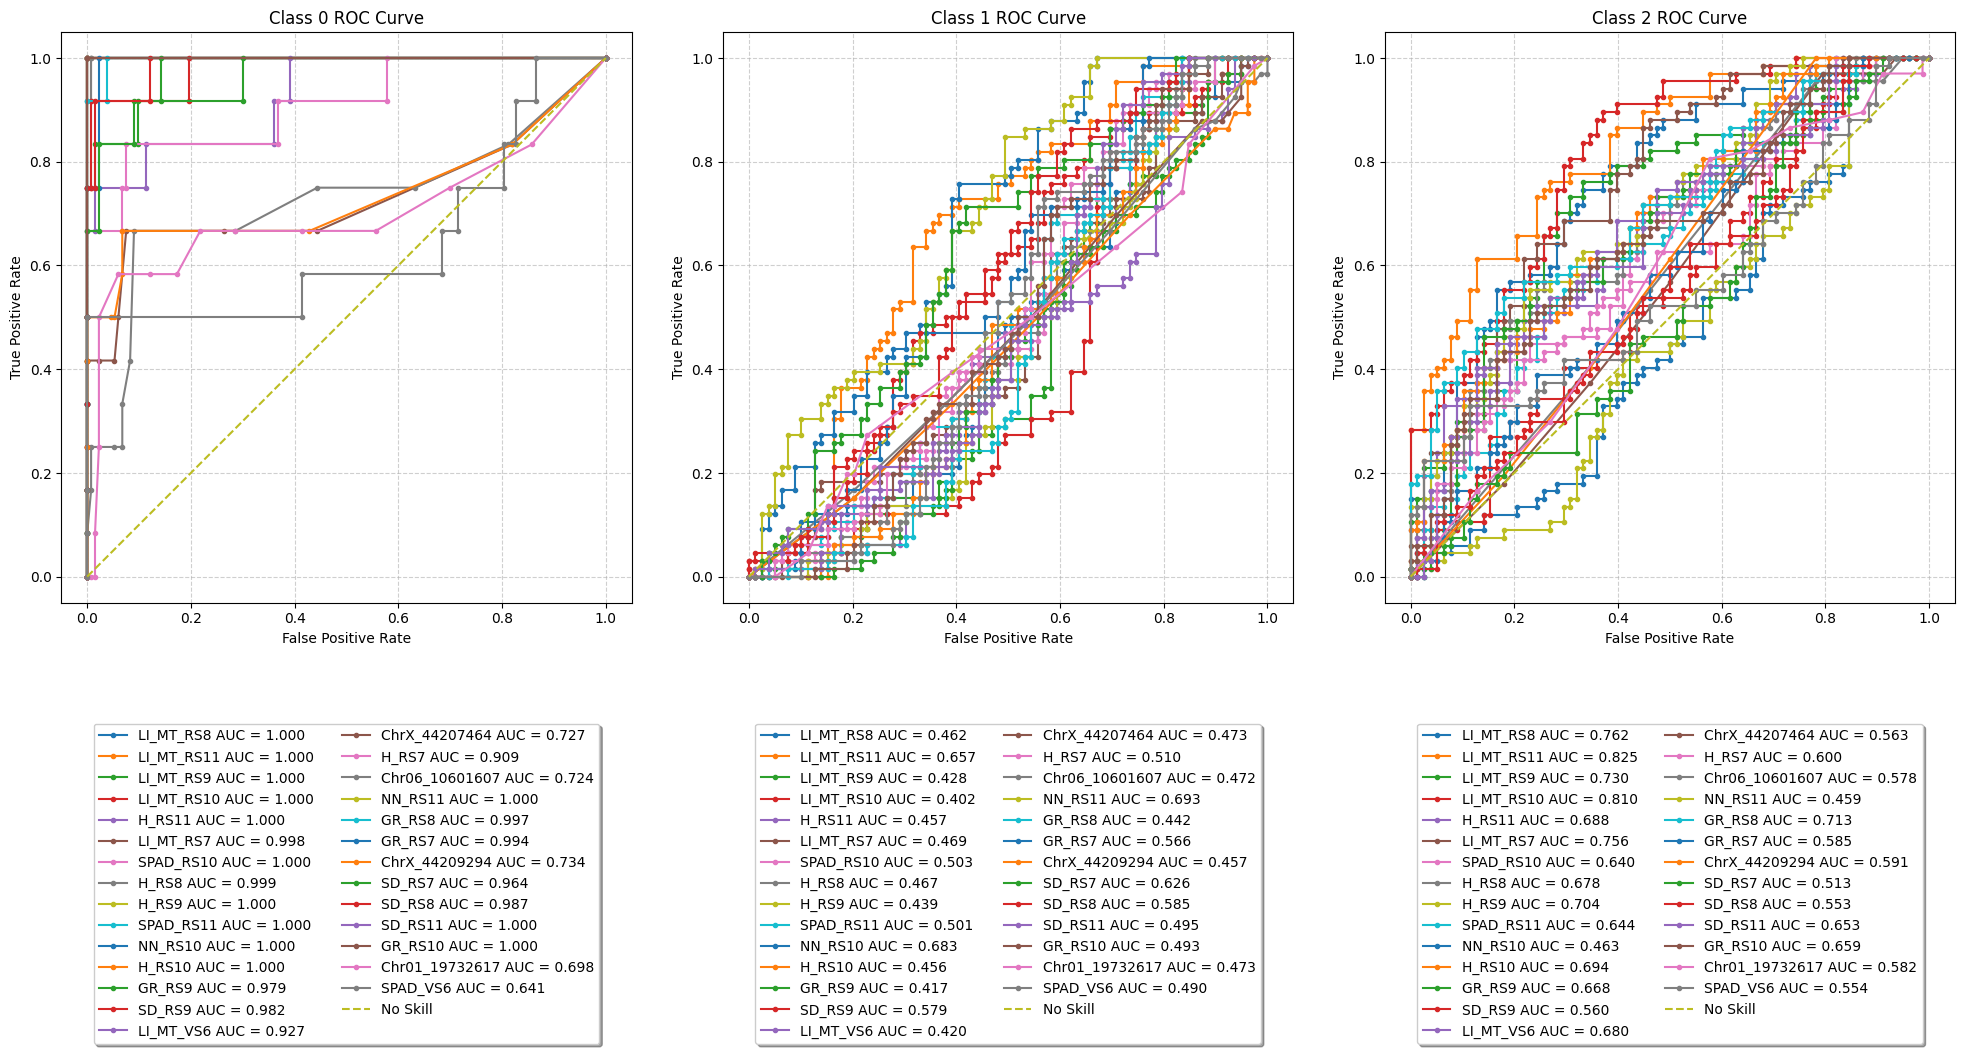

In [332]:
class_mapping = {"EarlyFlowering": 0, "MediumFlowering": 1, "LateFlowering": 2}
y_binary = np.array([class_mapping[label] for label in y])

Y_one_hot = label_binarize(y_binary, classes=[0, 1, 2])

plt.figure(figsize=(20, 20))  

for i in range(3):
    plt.subplot(1, 3, i + 1, aspect='equal') 
    plt.title(f'Class {i} ROC Curve')
    
    for idx, feature_name in zip(common, common_all):
        X_feature = X[:, idx].reshape(-1, 1)
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        lr_scores = cross_val_predict(LinearSVC(random_state=42), X_feature, y_binary, cv=cv, method='decision_function')
        
        if lr_scores.ndim > 1:
            y_score = lr_scores[:, i]
        else:
            y_score = lr_scores
        
        y_true = Y_one_hot[:, i]
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        
        plt.plot(fpr, tpr, marker='.', label=f'{feature_name} AUC = {auc:.3f}')
    
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fancybox=True, shadow=True) 
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


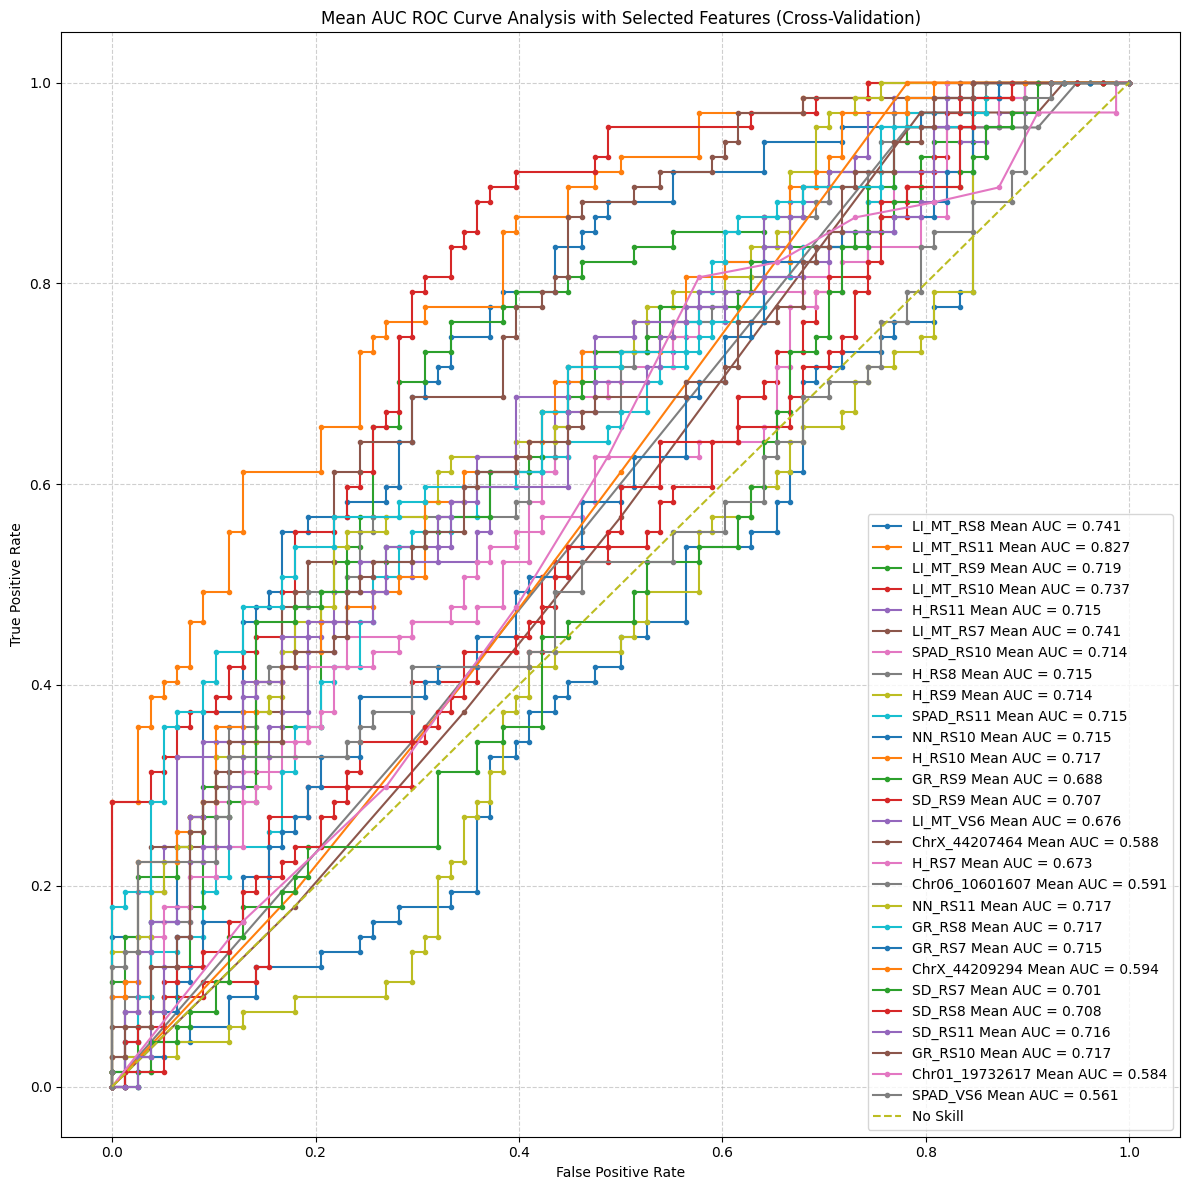

In [333]:

class_mapping = {"EarlyFlowering": 0, "MediumFlowering": 1, "LateFlowering": 2}
y_binary = np.array([class_mapping[label] for label in y])

Y_one_hot = label_binarize(y_binary, classes=[0, 1, 2])

plt.figure(figsize=(12, 12))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for idx, feature_name in zip(common, common_all):
    X_feature = X[:, idx].reshape(-1, 1)
    
    lr_scores = cross_val_predict(LinearSVC(random_state=42), X_feature, y_binary, cv=cv, method='decision_function')
    
    aucs = []
    
    for i in range(3):
        y_true = Y_one_hot[:, i]
        y_score = lr_scores
        
        if lr_scores.ndim > 1:
            y_score = lr_scores[:, i]
        
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        aucs.append(auc)
    
    mean_auc = np.mean(aucs)
    plt.plot(fpr, tpr, marker='.', label=f'{feature_name} Mean AUC = {mean_auc:.3f}')

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Mean AUC ROC Curve Analysis with Selected Features (Cross-Validation)")
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [334]:
####RFE
#Create a list with RFE features

RFEFC = list(set(rfe_f))

print("RFE: ", len(RFEFC))


RFE:  53


In [335]:
#A LinearSVC Model using the RFE features 
startTime = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = X_train[:, RFEFC]
X_test = X_test[:, RFEFC]
Y_train = y_train[:]
Y_test = y_test[:]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train[:]
Y_test = Y_test[:]
clf = LinearSVC(random_state=42)

clf.fit(X_train, Y_train)

endTime = time.time()
print('Score: ' + str(clf.score(X_test, Y_test)))
print('Time: ' + str(endTime - startTime))
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))


Score: 0.9655172413793104
Time: 4.434110641479492
[[ 2  0  0]
 [ 0 13  1]
 [ 0  0 13]]
                 precision    recall  f1-score   support

 EarlyFlowering       1.00      1.00      1.00         2
  LateFlowering       1.00      0.93      0.96        14
MediumFlowering       0.93      1.00      0.96        13

       accuracy                           0.97        29
      macro avg       0.98      0.98      0.98        29
   weighted avg       0.97      0.97      0.97        29

0.9655172413793104
(np.float64(0.9679802955665024), np.float64(0.9655172413793104), np.float64(0.9655172413793104), None)


In [336]:
rfe_f_names = []
for i in rfe_f:
  rfe_f_names.append(features_names[i])
df_RFE = pd.DataFrame(rfe_f_names)
df_RFE.to_csv(r'RFE_features.csv', index=False) 

Class Early: ROC AUC=1.000
Class Medium: ROC AUC=0.990
Class Late: ROC AUC=0.990
No Skill: ROC AUC=0.500
Model: ROC AUC=0.994


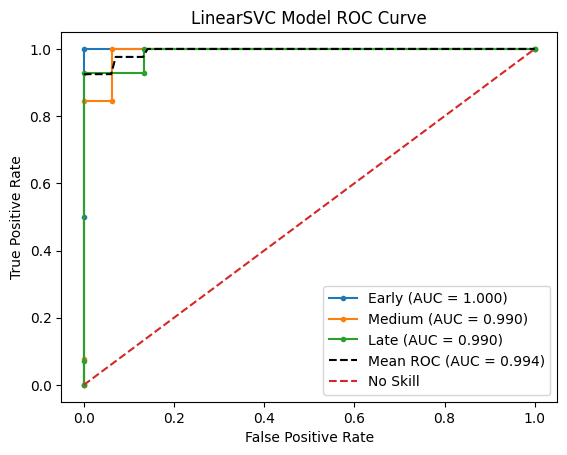

In [337]:
#ROC AUC calculations for LinearSVC Model using the RFE features 
class_mapping = {"EarlyFlowering": 0, "MediumFlowering": 1, "LateFlowering": 2}
short_class_mapping = {0: 'Early', 1: 'Medium', 2: 'Late'}

y_test_binary = np.array([class_mapping[label] for label in y_test])
y_train_binary = np.array([class_mapping[label] for label in y_train])

model = LinearSVC(random_state=42)
model.fit(X_train, y_train_binary)

lr_scores = model.decision_function(X_test)

lr_probs = softmax(lr_scores, axis=1)

Y_test_one_hot = label_binarize(y_test_binary, classes=[0, 1, 2])

ns_probs = np.zeros((len(y_test_binary), 3))
ns_probs[:, 2] = 1  

auc_scores = []
for i in range(3):
    auc = roc_auc_score(Y_test_one_hot[:, i], lr_probs[:, i])
    auc_scores.append(auc)
    print(f'Class {short_class_mapping[i]}: ROC AUC=%.3f' % (auc))

try:
    ns_auc = roc_auc_score(Y_test_one_hot, ns_probs, multi_class='ovr')
    lr_auc = roc_auc_score(Y_test_one_hot, lr_probs, multi_class='ovr')
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (lr_auc))
except ValueError as e:
    print(f"Error calculating ROC AUC: {e}")

plt.figure()
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)
for i in range(3):
    fpr, tpr, _ = roc_curve(Y_test_one_hot[:, i], lr_probs[:, i])
    plt.plot(fpr, tpr, marker='.', label=f'{short_class_mapping[i]} (AUC = {auc_scores[i]:.3f})')
    mean_tpr += np.interp(mean_fpr, fpr, tpr, left=0, right=1)

mean_tpr /= 3
plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', label=f'Mean ROC (AUC = {np.mean(auc_scores):.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("LinearSVC Model ROC Curve")

plt.legend()

plt.show()


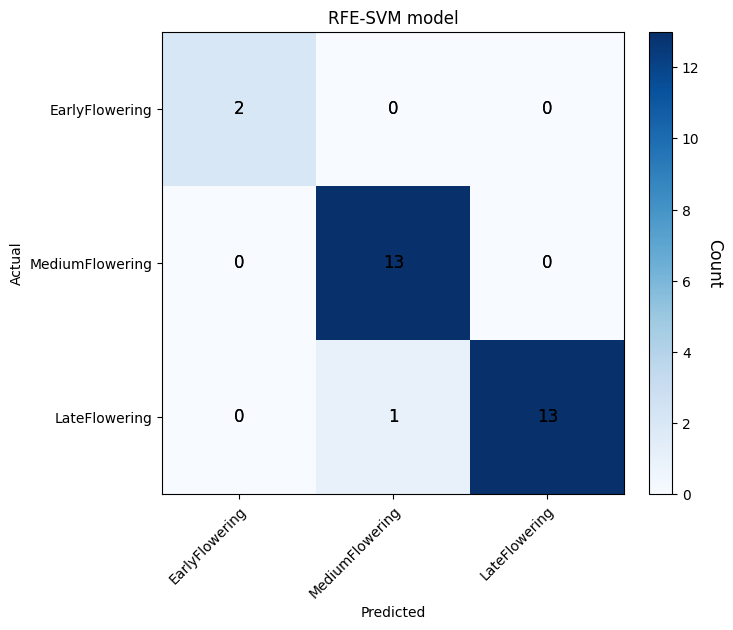

In [338]:
matrix_data = np.array([[2, 0, 0],
                        [0, 13, 0],
                        [0, 1, 13]])
class_names = ['EarlyFlowering', 'MediumFlowering', 'LateFlowering']


fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(matrix_data, cmap="Blues")

for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, f"{matrix_data[i, j]:.0f}",
                       ha="center", va="center", color="black", fontsize=12)

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, fontsize=10)
ax.set_yticklabels(class_names, fontsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel("Predicted", fontsize=10)
plt.ylabel("Actual", fontsize=10)
plt.title("RFE-SVM model", fontsize=12)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        ax.text(j, i, f"{matrix_data[i, j]:.0f}",
                ha="center", va="center", color="black", fontsize=12)

cbar = ax.figure.colorbar(im,  ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Count", rotation=-90, va="bottom", fontsize=12)

plt.show()


In [339]:
res = []
for l in ['EarlyFlowering', 'LateFlowering' , 'MediumFlowering']:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test)==l,
                                                      np.array(y_pred)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])
pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

#weighted specificity
specificity = ((res[0][1]*2)+(res[1][1]*14)+(res[2][1]*13))/29
print('Specificity: ', specificity)

#weighted sensitivity (recall)
sensitivity = ((res[0][2]*2)+(res[1][2]*14)+(res[2][2]*13))/29
print("Sensitivity: ", sensitivity)

Specificity:  0.9719827586206896
Sensitivity:  0.9655172413793104


In [340]:
#Balanced Accuracy
Balanced_Accuracy = (specificity+sensitivity)/2
print ("Balanced_Accuracy:", Balanced_Accuracy)

Balanced_Accuracy: 0.96875


In [341]:
pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

,class,specificity,sensitivity
0,EarlyFlowering,1.0000,1.000000
1,LateFlowering,1.0000,0.928571
2,MediumFlowering,0.9375,1.000000


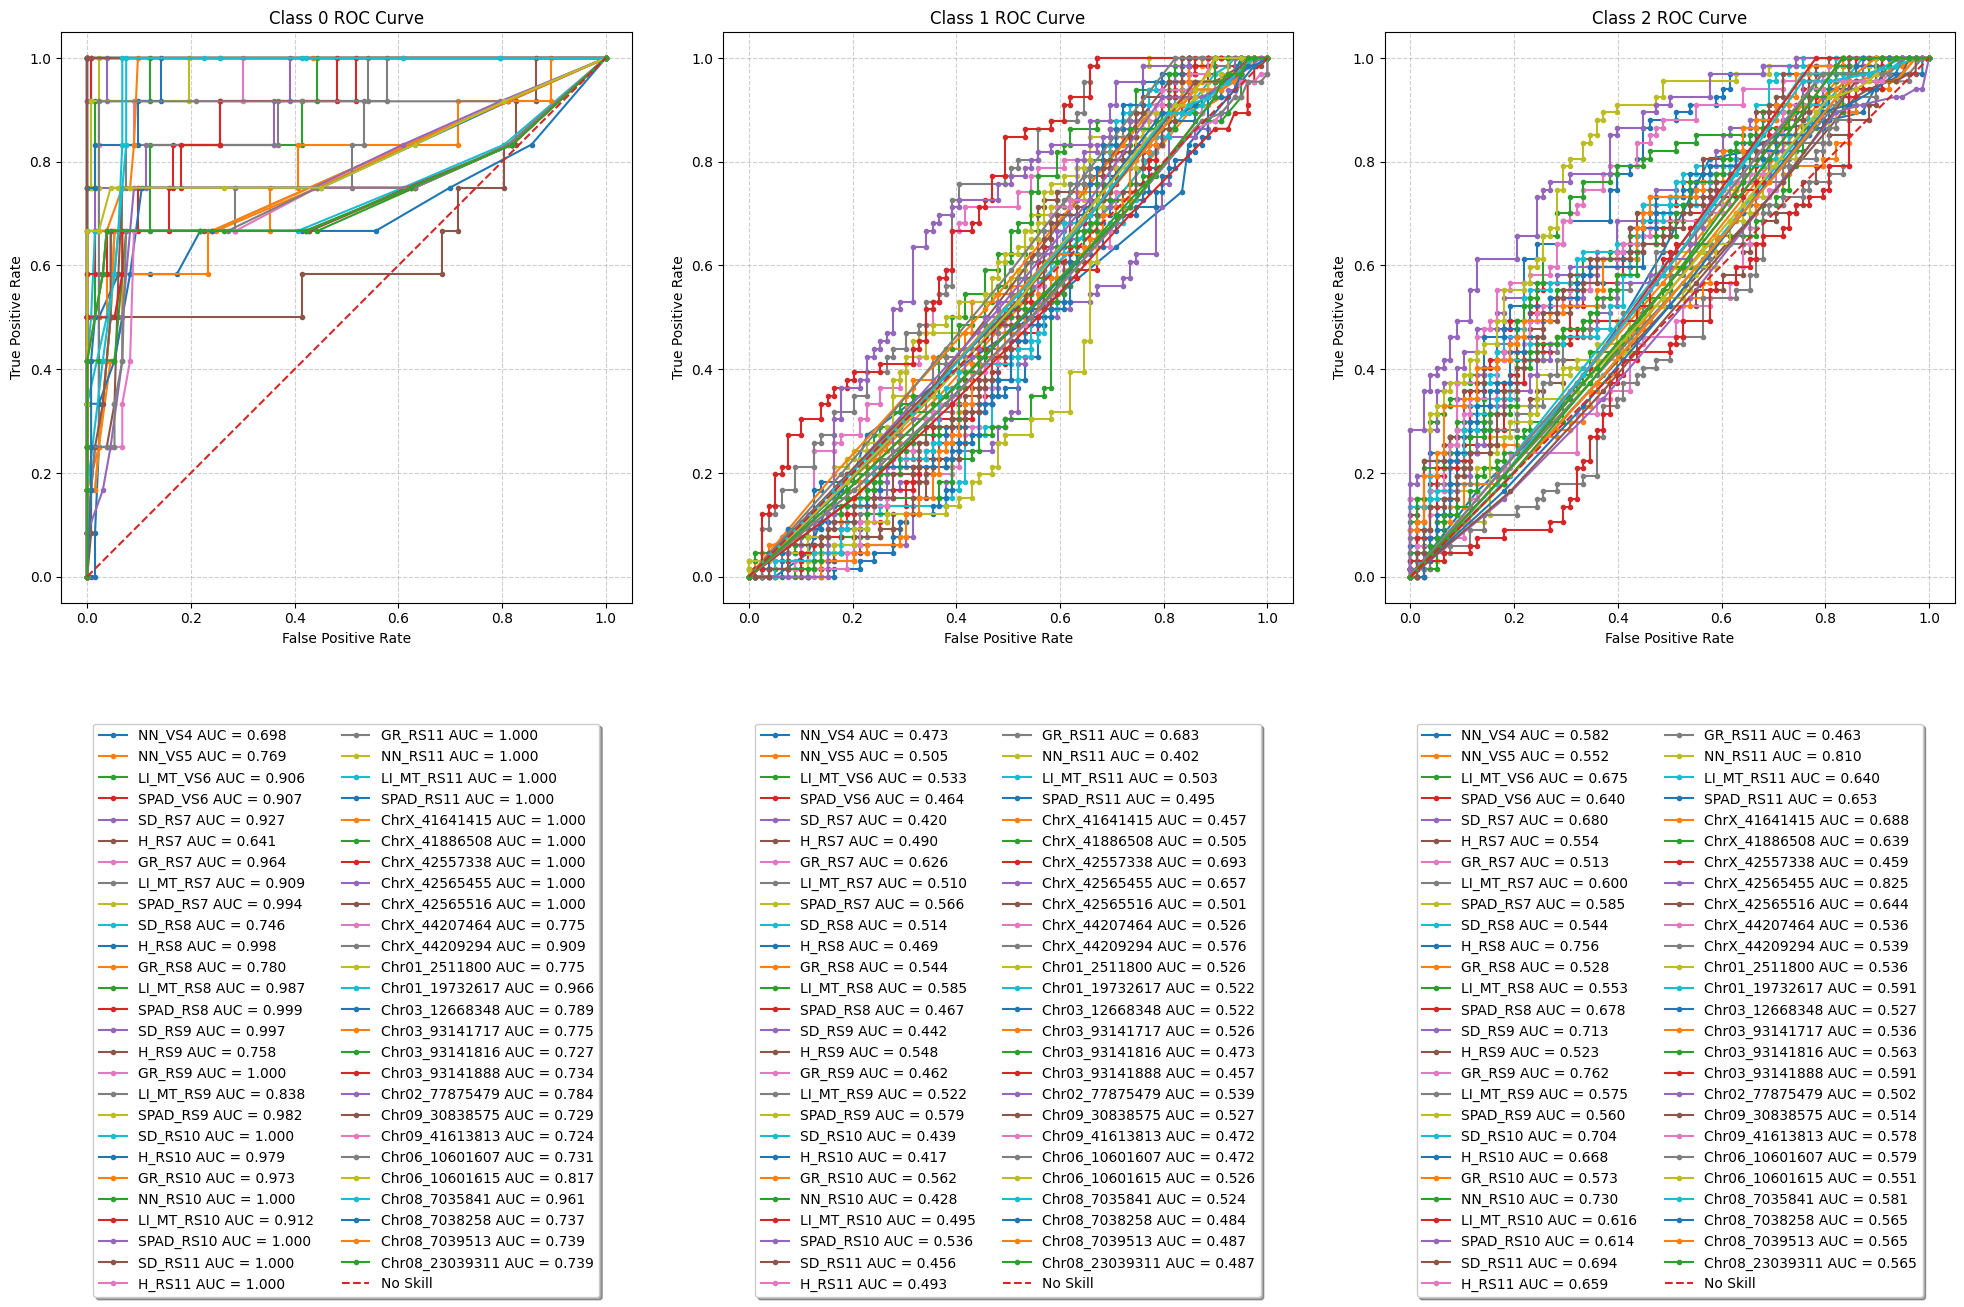

In [342]:
class_mapping = {"EarlyFlowering": 0, "MediumFlowering": 1, "LateFlowering": 2}
y_binary = np.array([class_mapping[label] for label in y])

Y_one_hot = label_binarize(y_binary, classes=[0, 1, 2])

plt.figure(figsize=(20, 20))  

for i in range(3):
    plt.subplot(1, 3, i + 1, aspect='equal') 
    plt.title(f'Class {i} ROC Curve')
    
    for idx, feature_name in zip(RFEFC, rfe_f_names):
        X_feature = X[:, idx].reshape(-1, 1)
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        lr_scores = cross_val_predict(LinearSVC(random_state=42), X_feature, y_binary, cv=cv, method='decision_function')
        
        if lr_scores.ndim > 1:
            y_score = lr_scores[:, i]
        else:
            y_score = lr_scores
        
        y_true = Y_one_hot[:, i]
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        
        plt.plot(fpr, tpr, marker='.', label=f'{feature_name} AUC = {auc:.3f}')
    
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fancybox=True, shadow=True) 
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


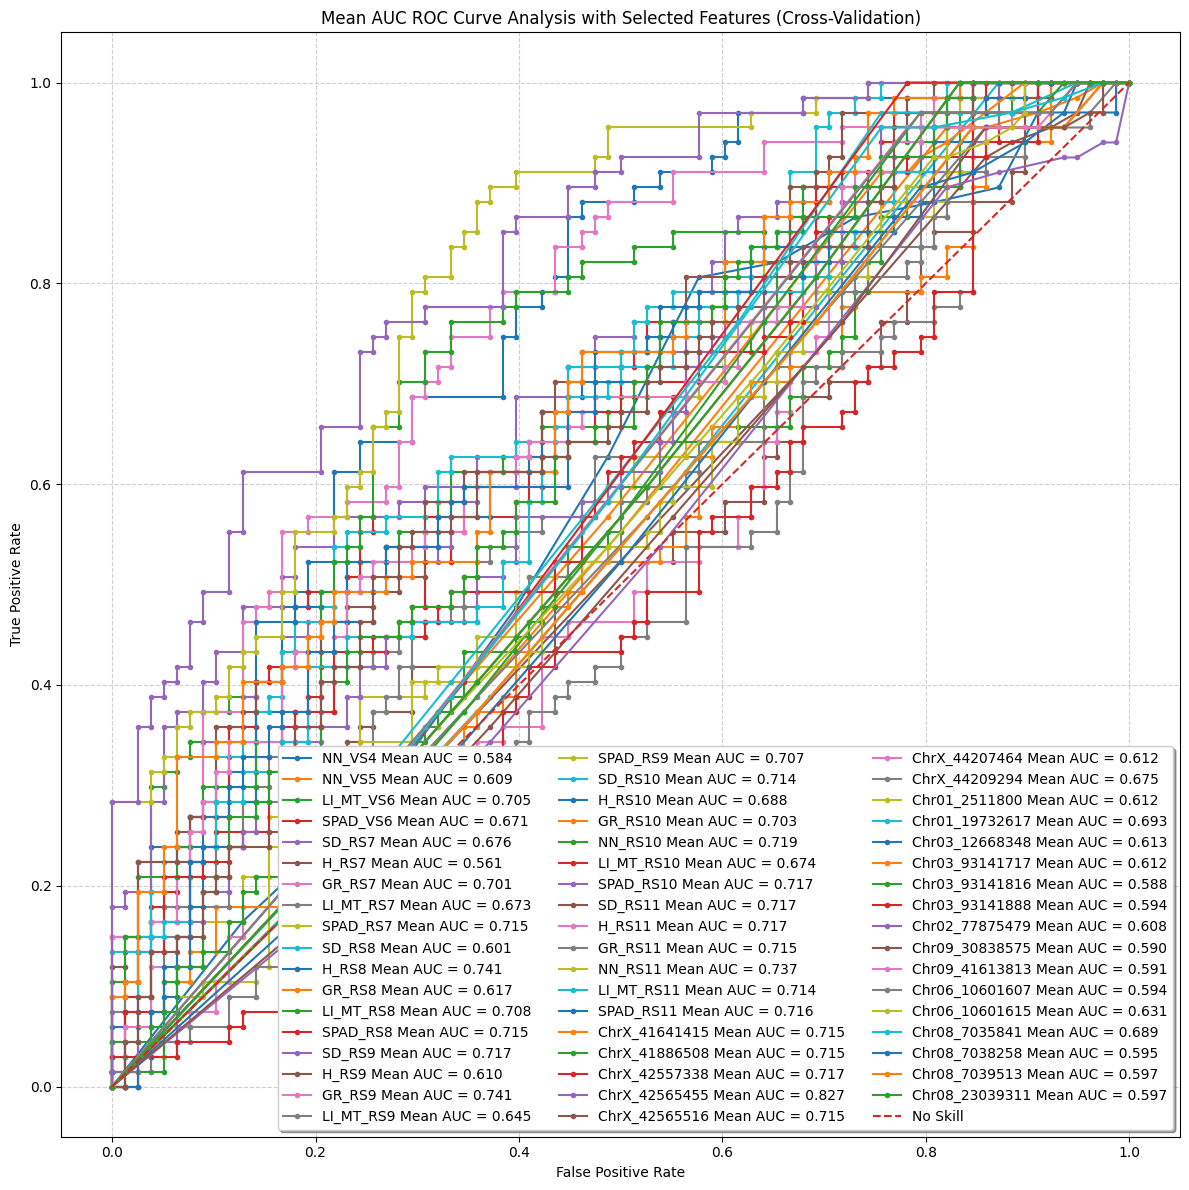

In [343]:

class_mapping = {"EarlyFlowering": 0, "MediumFlowering": 1, "LateFlowering": 2}
y_binary = np.array([class_mapping[label] for label in y])

Y_one_hot = label_binarize(y_binary, classes=[0, 1, 2])

plt.figure(figsize=(12, 12))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for idx, feature_name in zip(RFEFC, rfe_f_names):
    X_feature = X[:, idx].reshape(-1, 1)
    
    lr_scores = cross_val_predict(LinearSVC(random_state=42), X_feature, y_binary, cv=cv, method='decision_function')
    
    aucs = []
    
    for i in range(3):
        y_true = Y_one_hot[:, i]
        y_score = lr_scores
        
        if lr_scores.ndim > 1:
            y_score = lr_scores[:, i]
        
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        aucs.append(auc)
    
    mean_auc = np.mean(aucs)
    plt.plot(fpr, tpr, marker='.', label=f'{feature_name} Mean AUC = {mean_auc:.3f}')

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Mean AUC ROC Curve Analysis with Selected Features (Cross-Validation)")
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(ncol=3, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()


In [219]:
#Save in a Data Frame
similar_all_names = []
for i in similar_all:
  similar_all_names.append(features_names[i])
df_similar_All = pd.DataFrame(similar_all_names)
df_similar_All.to_csv(r'Similar_All_Features.csv', index=False) 

In [220]:
similar_rfe_MI_names = []
for i in similar_rfe_MI:
  similar_rfe_MI_names.append(features_names[i])
df_similar_rfe_MI = pd.DataFrame(similar_rfe_MI_names)
df_similar_rfe_MI.to_csv(r'Similar_RFE_MI_Features.csv', index=False) 

In [221]:
similar_rfe_RF_names = []
for i in similar_rfe_RF:
  similar_rfe_RF_names.append(features_names[i])
df_similar_rfe_RF = pd.DataFrame(similar_rfe_RF_names)
df_similar_rfe_RF.to_csv(r'Similar_RFE_RF_Features.csv', index=False) 

In [222]:
similar_MI_RF = []
for i in similarity:
  similar_MI_RF.append(features_names[i])
df_similar_MI_RF = pd.DataFrame(similar_MI_RF)
df_similar_MI_RF.to_csv(r'Similar_MI_RF_Features.csv', index=False) 

In [223]:
rfe_f_names = []
for i in rfe_f:
  rfe_f_names.append(features_names[i])
df_RFE = pd.DataFrame(rfe_f_names)
df_RFE.to_csv(r'RFE_features.csv', index=False) 

In [224]:
MI_f_names = []
for i in it:
  MI_f_names.append(features_names[i])
df_MI = pd.DataFrame(MI_f_names)
df_MI.to_csv(r'MI_features.csv', index=False) 

In [225]:
RF_f_names = []
for i in important_f:
  RF_f_names.append(features_names[i])
df_RF = pd.DataFrame(RF_f_names)
df_RF.to_csv(r'RF_features.csv', index=False) 

In [226]:
common_all = []
for i in common:
  common_all.append(features_names[i])
df_common = pd.DataFrame(common_all)
df_common.to_csv(r'common_all.csv', index=False) 